In [1]:
import pandas as pd
import numpy as np
import time
from math import ceil

In [2]:
sarcoid_hla = pd.read_csv('hla_table.csv')

In [3]:
sarcoid_scores = {}
for index, row in sarcoid_hla.iterrows():
    print(row['HLA allele'])
    key = row['HLA allele']
    sarcoid_scores.update({key:round(row['beta MA'],5)})

DRB1_101
DQA1_101
DQB1_501
DQB1_602
B_3501
DQB1_602
DQA1_102


In [4]:
allele_df = (pd
             .read_csv("/slade/projects/Research_Project-MRC158833/"
                       "UKBiobank/500K_Genetic_data/imputed_data/ukb_hla_v2.txt",
                       delimiter="\t", header=0, usecols=sarcoid_scores.keys()))

indices = (pd
           .read_csv("/slade/projects/Research_Project-MRC158833/"
                     "UKBiobank/500K_Genetic_data/imputed_data/ukb_hla_dosage_v2.indiv",
                     delimiter="\t", header=None, names=['n_eid', 'FID']))

In [5]:
allele_df.head()

,B_3501,DRB1_101,DQB1_501,DQB1_602,DQA1_101,DQA1_102
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
sarcoid_scores

{'DRB1_101': -1.07881,
 'DQA1_101': -0.75502,
 'DQB1_501': -0.63488,
 'DQB1_602': 0.38526,
 'B_3501': -0.75502,
 'DQA1_102': 0.30748}

In [7]:
def custom_round(number, threshold=0.7):
    if number - int(number) >= threshold:
#        print(number, int(number))
        return ceil(number)
    else:
        if 1<=number<1.5:
            return(1)
        elif number>1.5:
            return(2)
        else:
            return 0
# # Example data: DataFrame with alleles and their associated probabilities
# data = {
#     'Allele': ['A*01:01', 'A*02:01', 'B*35:01', 'B*07:02', 'A*01:01', 'A*02:01', 'B*35:01', 'B*07:02'],
#     'Probability': [0.7, 0.65, 0.72, 0.45, 1, 1.3, 1.51, 1.7]
# }
# df = pd.DataFrame(data)

# # Apply the custom rounding to the probability column
# df['Selected'] = df['Probability'].apply(custom_round)

# # Show the updated DataFrame
# print(df)

(-0.003, 0.25]    361357
(0.75, 1.0]       114910
(1.75, 2.0]         9637
(0.5, 0.75]         1845
(1.5, 1.75]          322
(0.25, 0.5]          268
(1.25, 1.5]           38
(1.0, 1.25]            0
Name: DQB1_602, dtype: int64

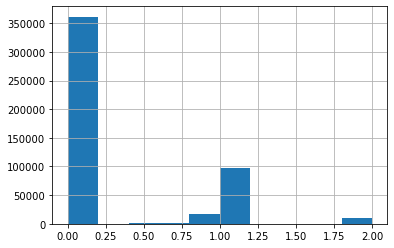

In [8]:
allele_df.DQB1_602.hist()
#allele_df.DRB1_1501.hist()
allele_df.DQB1_602.value_counts(bins=8)

In [9]:
for i in allele_df.columns:
    allele_df[i] = allele_df[i].apply(custom_round)

In [10]:
allele_df.DQB1_602.value_counts()

0    363016
1    115402
2      9959
Name: DQB1_602, dtype: int64

In [11]:
assert len(allele_df) == len(indices)

In [12]:
start_time = time.time()

risk_scores = []


for index, row in allele_df.iterrows():

#    print([row[col] for col in allele_df.columns])
    
    risk_score = sum(custom_round(row[col]) * sarcoid_scores.get(col, 0)
                     for col in allele_df.columns)
    risk_scores.append(risk_score)

    
# Stop the timer
end_time = time.time()

# Calculate the elapsed time for the entire DataFrame
elapsed_time = end_time - start_time
print(elapsed_time)

31.41910982131958


In [13]:
master_df = pd.concat([indices, allele_df], axis=1)
master_df['Sarcoid_HLA_GRS'] = risk_scores

In [15]:
master_df.head()

,n_eid,FID,B_3501,DRB1_101,DQB1_501,DQB1_602,DQA1_101,DQA1_102,Sarcoid_HLA_GRS
0,5487330,5487330,0,0,0,0,0,0,0.00000
1,2190141,2190141,0,0,0,1,0,1,0.69274
2,5787554,5787554,0,1,1,0,1,0,-2.46871
3,4202126,4202126,0,0,0,1,0,1,0.69274
4,4895751,4895751,0,0,0,0,0,0,0.00000


In [27]:
master_df.to_csv('/slade/home/pl450/Uveitis/GRS/Sarcoidosis/Sarcoidosis_HLA/Sarcoidosis_HLA_GRS_010524.tsv',
                sep='\t', index=None)